In [2]:
from moleculekit.molecule import Molecule
import jax_md
import os
# load alanine dipeptide
testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

2023-05-14 12:22:17,731 - jax._src.lib.xla_bridge - INFO - Remote TPU is not linked into jax; skipping remote TPU.
2023-05-14 12:22:17,732 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
2023-05-14 12:22:17,732 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-14 12:22:17,735 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-14 12:22:17,736 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2023-05-14 12:22:17,737 - jax._src.lib.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (d

In [3]:
# use this utility from tochmd, since it doesn't require tor (could port and remove dependenctogethery on torchmd altogether)
from torchmd.forcefields.forcefield import ForceField
ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))

In [4]:
from parameters import Parameters, set_box, set_positions
import jax.numpy as nnp

In [5]:
parameters = Parameters(ff, mol, precision=float, device='cpu')
nreplicas = 1 # don't change
pos = set_positions(nreplicas, mol.coords)
box = nnp.array(set_box(nreplicas, mol.box), dtype='float32')


In [6]:
from forces import Forces
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])

Calculating the potential should result in the same value, -2190.6, as the original TorchMD code at https://github.com/torchmd/torchmd/blob/master/examples/tutorial.ipynb:

In [7]:
forces.compute(pos, box)

/Users/reubencohn-gordon/miniconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/Users/reubencohn-gordon/miniconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/Users/reubencohn-gordon/miniconda3/lib/python3.8/site-packages/jax/_src/ops/scatter.py:87: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: c

Array(-2190.6232048, dtype=float64)

In [8]:
# plotting utilities

import numpy.linalg as npl
import seaborn as sns
import matplotlib.pyplot as plt 
from plotting import rama_plot
from jax_md.simulate import Sampler
from jax_md import space, quantity
from jax_md import simulate, energy
import math
import jax

2023-05-14 12:22:33,475 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [28]:
nlogp = lambda x : forces.compute(nnp.reshape(x, pos.shape), box)/300
# nlogp = lambda x : -((x**2)/100).sum()
value_grad = jax.value_and_grad(nlogp)

class MD():


  def __init__(self, d):
    self.d = d

  def grad_nlogp(self, x):
    """should return nlogp and gradient of nlogp"""
    return value_grad(x)

  def transform(self, x):
    # return x[:2] 
    return x

  def prior_draw(self, key):
    """Args: jax random key
       Returns: one random sample from the prior"""
    return nnp.array(nnp.reshape(pos, math.prod(pos.shape)), dtype='float64')


# TODO: correct periodic boundary conditions cause error``
# displacement_fn, shift_fn = space.periodic_general(nnp.diag(box[0]))
displacement_fn, shift_fn = space.periodic(box[0][0][0].item())

target = MD(d = math.prod(pos.shape))
sampler = Sampler(target, shift_fn=shift_fn)


In [29]:

chain_length = 100
num_chains = 1
samples = sampler.sample(chain_length, num_chains)



In [32]:
from jax_md.simulate import AnnealingSampler

annealingsampler = AnnealingSampler(target, shift_fn=shift_fn)

# ...

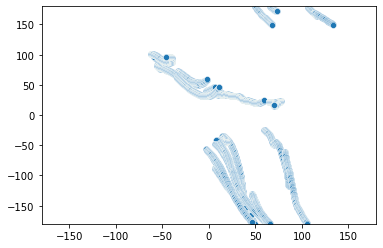

In [27]:
rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[::1, :]])


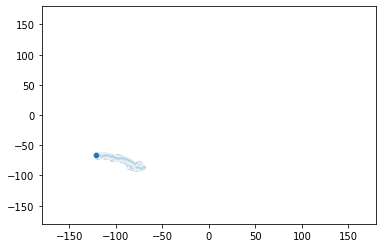

In [15]:

rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[::1, :]])
# rama_plot(nnp.reshape(samples[:, ::10, :], (int(chain_length * num_chains / 10), 1, 688, 3)))


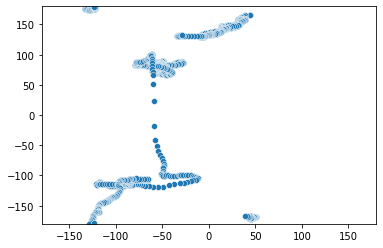

In [109]:
rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[::100, :]])
# [nnp.reshape(s, (1,688,3)) for s in samples[2]][0].shape
# samples[:, ::10, :].shape

# rs = nnp.reshape(samples[:, ::10, :], (int(chain_length * num_chains / 10), 1, 688, 3))
# rama_plot(list(rs))

# rama_plot(list(nnp.reshape(samples[0], (100, 688, 3))))
# [nnp.reshape(s, (1,688,3)) for s in samples]
# data = pd.DataFrame(data = samples[:,0], columns=['x'])
# histplot(data=data,x='x')
# samples

Array([[ 3.98288554, 11.5367616 ,  4.87755467, ...,  2.19234915,
         7.8511376 ,  6.24209082],
       [ 3.98281054, 11.53675704,  4.87754933, ...,  2.19238185,
         7.85113563,  6.24212326],
       [ 3.98273715, 11.53675292,  4.87754481, ...,  2.19241372,
         7.85113225,  6.24215381],
       ...,
       [ 3.98234508, 11.53672867,  4.87753249, ...,  2.19256682,
         7.85110593,  6.24231867],
       [ 3.98226598, 11.53672367,  4.87753237, ...,  2.19259658,
         7.85109992,  6.24235454],
       [ 3.98218976, 11.5367183 ,  4.87753341, ...,  2.19262647,
         7.851094  ,  6.24239124]], dtype=float64)

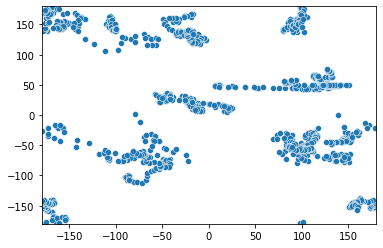

In [84]:
# rama_plot([nnp.reshape(s, (1,688,3)) for s in samples[11]])
# samples[8]
# [nnp.reshape(s, (1,688,3)) for s in samples[2]][0].shape
# samples[:, ::10, :].shape

rs = nnp.reshape(samples[:, ::1, :], (int(chain_length * num_chains / 1), 1, 688, 3))
rama_plot(list(rs))

# rama_plot(list(nnp.reshape(samples[0], (100, 688, 3))))
# [nnp.reshape(s, (1,688,3)) for s in samples]
# data = pd.DataFrame(data = samples[:,0], columns=['x'])
# histplot(data=data,x='x')
# samples

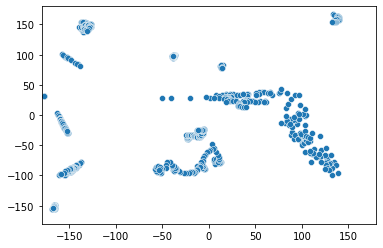

In [99]:
# rama_plot([nnp.reshape(s, (1,688,3)) for s in samples])

# samples[:, ::10, :].shape
rs = nnp.reshape(samples[:, ::1, :], (int(chain_length * num_chains / 1), 1, 688, 3))
rama_plot(list(rs))

# rama_plot(list(nnp.reshape(samples[0], (100, 688, 3))))
# [nnp.reshape(s, (1,688,3)) for s in samples]
# data = pd.DataFrame(data = samples[:,0], columns=['x'])
# histplot(data=data,x='x')
# samples

In [ ]:
# ## run nvt

# from jax_md import space, quantity
# from jax_md import simulate, energy
# import jax.numpy as jnp
# import jax
# from jax import random
# import jax.numpy as np

# key = jax.random.PRNGKey(0)

# # keys = jax.random.split(key)

# # displacement_fn, shift_fn = space.periodic(box[0][0])
# # displacement_fn, shift_fn = space.periodic(box[0][0])



# # # print(box.shape, "box shape")
# # # print(forces.compute(pos,box))
# def energy_fn(x):
#   # print(x.shape, "SHAPE")
#   # print(comp(x,box), "comp")
#   return forces.compute(x, box)
# # # energy_fn = lambda x : forces.compute(jnp.reshape(x, pos.shape), box)

# # R = jax.random.uniform(keys[0], (688, 3))

# # box_size = 19
# displacement_fn, shift_fn = space.periodic(box[0][0][0].item())

# N = 688
# spatial_dimension = 3
# key = random.PRNGKey(0)
# R = random.uniform(key, (1, N, spatial_dimension), minval=0.0, maxval=1.0)
# # energy_fn = energy.lennard_jones_pair(displacement_fn)
# # print('E = {}'.format(energy_fn(R)))
# # force_fn = quantity.force(energy_fn)
# # print('Total Squared Force = {}'.format(np.sum(force_fn(R) ** 2)))


# temperature = 300.0
# dt = 1e-3
# init, update = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, temperature)
# state = init(key, R)
# traj = []
# gs = []
# cs = []
# for i in range(10):
#   if i%1==0:
#     traj.append(state.position)
#     gs.append(jax.grad(lambda x : forces.compute(x, box))(state.position))
#     cs.append((lambda x : forces.compute(x, box))(state.position))
    
#   state = update(state)
# R = state.position
# R